# Visual Plant Recognition

This Jupyter Notebook uses a pre-trained Inception v3 architecture to train on the [Oxford 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). The dataset consists of 102 different plants. PyTorch is used as a framework.

## Dataset Loading

Importing all the necessary frameworks, libraries and classes

In [1]:
from pathlib import Path
import copy
from matplotlib import pyplot as plt
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import KFold
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from helper import convert_mat_to_csv
from dataset_loader import Oxford102Dataset, Rescale, RandomCrop, ToTensor, Normalize
from visualization import image_visualization, batch_visualization
from model import SimpleNet, resNet_152
from training import train_epoch
from evaluation import evaluation, per_class_accuracy, worst_classes

Converting the MatLab files with the labels into a csv

In [2]:
path_dataset = Path("../dataset/")
if not(path_dataset.joinpath("imagelabels.csv").exists()):
    convert_mat_to_csv(path_dataset.joinpath("imagelabels.mat"))
    print("Created image labels")
else: 
    print("Image labels already exist as csv")
if not(path_dataset.joinpath("setid.csv").exists()):    
    convert_mat_to_csv(path_dataset.joinpath("setid.mat"))
    print("Created set id")
else: 
    print("Set id already exist as csv")

Image labels already exist as csv
Set id already exist as csv


8189


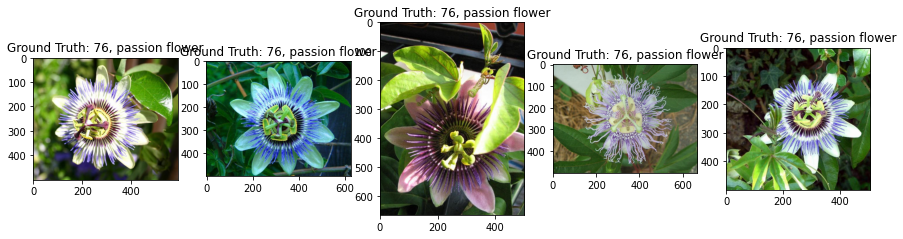

In [3]:
oxford102Dataset = Oxford102Dataset(csv_file='../dataset/imagelabels.csv',
                                    dataset_dir='../dataset/')

batch_visualization(oxford102Dataset, (1, 5), (15, 4))
    


<Figure size 432x288 with 0 Axes>

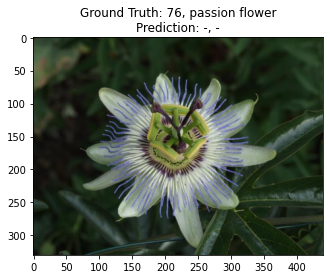

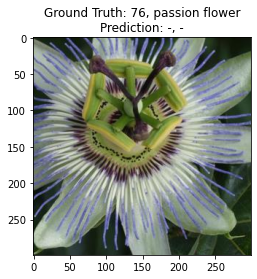

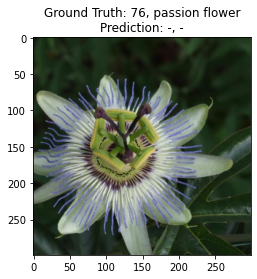

In [4]:
scale = Rescale(330)
crop = RandomCrop(299)
composed = transforms.Compose([Rescale(330),
                               RandomCrop(299)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = oxford102Dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    image_visualization(transformed_sample['image'], sample['plant_label'])


plt.show()

Putting everything together and iterating trough the dataset with dataloader

Loading the Oxford 102 Dataset with a custome dataloader and visualise it

In [5]:
transformed_dataset = Oxford102Dataset(csv_file='../dataset/imagelabels.csv',
                                    dataset_dir='../dataset/', transform=transforms.Compose([
        RandomCrop(224),
        ToTensor(),
        Normalize()]))

train_len = int(0.8 * len(transformed_dataset))
train_data, test_data = random_split(transformed_dataset, [train_len, 
                                                           len(transformed_dataset)-train_len], 
                                                             generator=torch.Generator().manual_seed(1))
train_dataloader = DataLoader(train_data, batch_size=32,
                        shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=32,
                        shuffle=True, num_workers=4)

8189


## Training

In [6]:
# instanciate model
model = SimpleNet()

# move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model.cuda()
    
# loss function
# TODO: reduction = sum
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-6)

In [7]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

In [8]:
def train(n_epochs, train_dataset, model, optimizer, loss_function, use_cuda, batch_size=32, k_splits = 5):
    # tensorboard
    writer = SummaryWriter()

    # cross validation
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    kfold = KFold(n_splits=k_splits, shuffle=True, random_state=1)
    for fold, (train_idx, test_idx) in enumerate(kfold.split(np.arange(len(train_dataset)))):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        valid_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
        valid_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_subsampler)
        
        model.apply(init_weights)

        # pre-training evaluation
        train_eval = evaluation(model, train_dataloader, loss_function, use_cuda)
        validation_eval = evaluation(model, valid_dataloader, loss_function, use_cuda)
        writer.add_scalars(f'Loss/fold: {fold + 1}', {'training': train_eval[0], 'validation': validation_eval[0]}, global_step=0)
        writer.add_scalars(f'Accuracy/fold: {fold + 1}', {'training': train_eval[1], 'validation': validation_eval[1]}, global_step=0)

        # Visualization
        fig = per_class_accuracy(train_eval[2])
        writer.add_figure(f'Accuracy per class', fig, global_step=0)
        fig = worst_classes(train_eval[2], 5)
        writer.add_figure(f'Worst classes', fig, global_step=0)

        for epoch in range(1, n_epochs+1):
            train_epoch(model, train_dataloader, optimizer, loss_function, use_cuda)
            # evaluation
            train_eval = evaluation(model, train_dataloader, loss_function, use_cuda)
            validation_eval = evaluation(model, valid_dataloader, loss_function, use_cuda)
            writer.add_scalars(f'Loss/fold: {fold + 1}', {'training': train_eval[0], 'validation': validation_eval[0]}, global_step=epoch)
            writer.add_scalars(f'Accuracy/fold: {fold + 1}', {'training': train_eval[1], 'validation': validation_eval[1]}, global_step=epoch)

            # Visualization
            fig = per_class_accuracy(train_eval[2])
            writer.add_figure(f'Accuracy per class', fig, global_step=epoch)
            fig = worst_classes(train_eval[2], 5)
            writer.add_figure(f'Worst classes', fig, global_step=epoch)
            
            print(f"Split {fold + 1}, Epoch {epoch} - Loss: {train_eval[0]} - Acc: {train_eval[1]}")
            
        validation_eval = evaluation(model, valid_dataloader, loss_function, use_cuda)
        if  validation_eval[1] > best_acc:
                best_acc = validation_eval[1]
                best_model_wts = copy.deepcopy(model.state_dict())
                print("Saved model")
    return model


In [9]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 191.959MB


In [ ]:
# train the model
model_scratch = train(4, train_data, model, optimizer, 
                      loss_function, use_cuda, k_splits=4)

In [ ]:
model_resnet152 = resNet_152(1000, 6)

In [ ]:
model_scratch = train(5, train_data, model, optimizer, 
                      loss_function, use_cuda, k_splits=50)